In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow as tf

In [72]:
dataset = pd.read_csv("labeled_data.csv")
dataset["labels"] = dataset["class"].map({
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither Hate Nor Offensive"
})
data = dataset[["tweet","class"]]
data.shape

(24783, 2)

In [73]:
set_stopwords = set(stopwords.words("English"))

In [74]:
stemmer = nltk.SnowballStemmer(language = "english")

In [75]:
# DATA CLEANING
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub("https?://\S+|www.\S+",'',tweet)
    tweet = re.sub('\[.?\]','',tweet)
    tweet = re.sub("\[%s\]"%re.escape(string.punctuation),'',tweet)
    tweet = re.sub('\n','',tweet)
    tweet = re.sub('\w\d\w','',tweet)
    tweet = [word for word in tweet.split(' ') if word not in set_stopwords]
    tweet = " ".join(tweet)
    tweet = [stemmer.stem(word) for word in tweet.split(' ')]
    tweet = " ".join(tweet)
    return tweet

In [76]:
data.loc[:,"tweet"] = data.loc[:,"tweet"].apply(clean_tweet) 

In [77]:
X = np.array(data["tweet"])
Y = np.array(data["class"])
Y

array([2, 1, 1, ..., 1, 1, 2], dtype=int64)

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

In [79]:
cv = CountVectorizer()
X = cv.fit_transform(X)

In [80]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 55)

In [81]:
for i in Y_test:
    print(i)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
0
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
2
1
2
1
1
1
2
1
1
1
0
0
1
1
2
1
0
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
2
2
1
1
1
2
1
1
2
1
2
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
0
2
1
1
1
1
1
2
1
1
1
2
1
1
2
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
2
1
2
1
1
1
2
0
1
1
1
1
1
2
1
1
1
1
1
0
1
2
2
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
2
1
1
1
1
1
1
1
1
1
2
1
2
1
2
1
2
1
2
2
1
1
1
0
2
1
1
2
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
2
1
2
2
1
1
1
1
1
1
1
1
1
1
0
1
2
1
1
2
1
1
2
1
1
1
1
2
1
1
1
2
2
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
0
1
2
1
2
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
2
1
1
1
1
0
2
1
2
1
2
1
1
2
1
1
1
1
1
2
1
1
2
1
1
1
2
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
0
1
1
1
1
2
1
2
2
2
1
1
1
1
1
1
1
1
2
2
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
0
1
1
2
0
1
1
1
2
1
2
1


In [82]:
from tensorflow.keras.utils import to_categorical

# Convert class labels to one-hot encoded format
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

In [83]:
for i in Y_test:
    print(i)

[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [85]:
X_train
type(X_train)

scipy.sparse._csr.csr_matrix

In [86]:
model = Sequential([
    Dense(units = 100, activation = "relu"),
    Dense(units = 50, activation = "relu"),
    Dense(units = 10, activation = "relu"),
    Dense(units = 3, activation = 'softmax')
])

In [87]:
model

In [88]:
from tensorflow.keras.losses import categorical_crossentropy

In [89]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [90]:
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x00000190A411F0D0>>

In [91]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)


In [92]:
X_train = tf.sparse.reorder(X_train)
type(X_train)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [93]:
model.fit(X_train,Y_train,epochs = 25, batch_size = 100)

Epoch 1/25
186/186 [==============================] - 9s 41ms/step - loss: 0.4635 - accuracy: 0.8442
Epoch 2/25
186/186 [==============================] - 7s 37ms/step - loss: 0.1734 - accuracy: 0.9408
Epoch 3/25
186/186 [==============================] - 7s 35ms/step - loss: 0.0659 - accuracy: 0.9794
Epoch 4/25
186/186 [==============================] - 7s 36ms/step - loss: 0.0279 - accuracy: 0.9913
Epoch 5/25
186/186 [==============================] - 7s 35ms/step - loss: 0.0152 - accuracy: 0.9957
Epoch 6/25
186/186 [==============================] - 7s 35ms/step - loss: 0.0089 - accuracy: 0.9971
Epoch 7/25
186/186 [==============================] - 7s 36ms/step - loss: 0.0058 - accuracy: 0.9981
Epoch 8/25
186/186 [==============================] - 7s 35ms/step - loss: 0.0049 - accuracy: 0.9986
Epoch 9/25
186/186 [==============================] - 7s 36ms/step - loss: 0.0037 - accuracy: 0.9987
Epoch 10/25
186/186 [==============================] - 7s 36ms/step - loss: 0.0039 - accura

In [94]:
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [95]:
X_test = tf.sparse.reorder(X_test)

In [96]:
Y_pred = model.predict(X_test)

194/194 [==============================] - 0s 1ms/step


In [97]:
from sklearn.metrics import accuracy_score

In [98]:
Y_pred

array([[7.4648724e-06, 9.9476707e-01, 5.2254926e-03],
       [6.2392013e-07, 9.9999940e-01, 1.3143161e-08],
       [5.8491096e-08, 9.9999905e-01, 1.0084063e-06],
       ...,
       [9.7058446e-06, 9.9998999e-01, 3.9773394e-07],
       [8.9164329e-09, 1.0000000e+00, 1.1914040e-08],
       [7.6113844e-13, 1.0000000e+00, 7.3102982e-12]], dtype=float32)

In [99]:
Y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [100]:
length = len(Y_pred)
output = np.zeros(length)
test = np.zeros(length)
for i in range(length):
    output[i] = np.argmax(Y_pred[i])
    test[i] = np.argmax(Y_test[i])

In [101]:
output

array([1., 1., 1., ..., 1., 1., 1.])

In [102]:
test

array([1., 1., 1., ..., 1., 1., 1.])

In [103]:
print(accuracy_score(output,test))

0.8829890251775339


Text(8.222222222222223, 0.5, 'Truth')

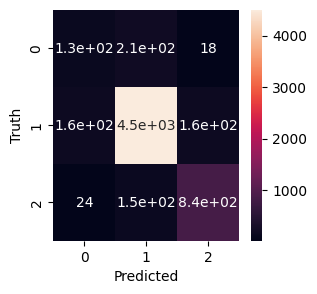

In [106]:
cm  = confusion_matrix(output,test)
plt.figure(figsize = (3,3))
sn.heatmap(cm,annot = True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [107]:
cm

array([[ 129,  207,   18],
       [ 161, 4502,  163],
       [  24,  152,  840]], dtype=int64)